
Required to work:

Plotly (pip install plotly)

pandas_datareader (pip install pandas_datareader)

datetime

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import sqrt

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn import preprocessing, svm, cross_validation
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader.data import DataReader


/Users/peterparikka/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



 Read in data

In [2]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195/
end = dt.datetime.now()
start = end - dt.timedelta(days=5*365)

df_tesla = DataReader('TSLA', 'iex', start, end)
df_tesla.index = pd.to_datetime(df_tesla.index, format='%Y-%m-%d')
# Drop row if null
df_tesla.dropna(inplace=True)


5y


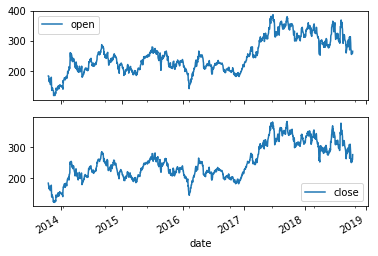

In [3]:

fig = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

df_tesla[['open']].plot(ax=ax1)
df_tesla[['close']].plot(ax=ax2)

plt.legend(loc=4)

plt.show()

Log feature type 1

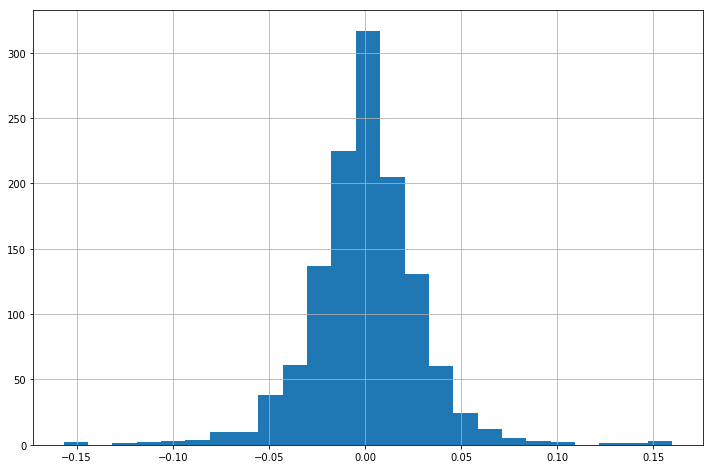

In [4]:
df_tesla['Log_Ret'] = np.log(df_tesla['close'] / df_tesla['close'].shift(1))
df_tesla['Log_Ret'].hist(bins=25, figsize=(12,8))


In [5]:

trace = go.Candlestick(x=df_tesla.index,
                       open=df_tesla.open,
                       high=df_tesla.high,
                       low=df_tesla.low,
                       close=df_tesla.close)

layout = go.Layout(
        xaxis = dict(
        rangeslider = dict(
            visible = False
        )
    )
)

data = [trace]

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename='tesla_candelStick')

In [6]:
df_tesla.dropna(inplace=True)


Rolling avrage feature type 2

In [7]:
df_tesla['R_AVG'] = df_tesla['close'].rolling(window=5).mean()


BIAS6 feature type 2

In [8]:
df_tesla['R_AVG6'] = df_tesla['close'].rolling(window=6).mean()

df_tesla['BIAS6'] = ((df_tesla['close'] - df_tesla['R_AVG6']) / df_tesla['R_AVG6']) * 100.00


In [9]:
df_tesla.drop(['R_AVG6'], 1, inplace=True)
df_tesla.dropna(inplace=True)


ROC feature type 1

In [10]:
def ROC(df, n):
    M = df['close'].diff(n -1)
    N = df['close'].shift(n -1)
    roc = pd.Series(((M / N) * 100), name = 'roc_' + str(n))   
    return roc

roc_series = ROC(df_tesla, 14)

df_tesla['ROC_14'] = roc_series
df_tesla.dropna(inplace=True)


In [11]:
INCREASING_COLOR = '#00FFFF'
DECREASING_COLOR = '#000000'

In [12]:
data = [ dict(
    type = 'candlestick',
    open = df_tesla.open,
    high = df_tesla.high,
    low = df_tesla.low,
    close = df_tesla.close,
    x = df_tesla.index,
    yaxis = 'y2',
    name = 'GS',
    increasing = dict( line = dict( color = INCREASING_COLOR ) ),
    decreasing = dict( line = dict( color = DECREASING_COLOR ) ),
) ]

layout=dict()

fig = dict( data=data, layout=layout )

In [13]:
fig['layout'] = dict()
fig['layout']['plot_bgcolor'] = 'rgb(250, 250, 250)'
fig['layout']['xaxis'] = dict( rangeselector = dict( visible = True ) )
fig['layout']['yaxis'] = dict( domain = [0, 0.2], showticklabels = False )
fig['layout']['yaxis2'] = dict( domain = [0.2, 0.8] )
fig['layout']['legend'] = dict( orientation = 'h', y=0.9, x=0.3, yanchor='bottom' )
fig['layout']['margin'] = dict( t=40, b=40, r=40, l=40 )

In [14]:
rangeselector=dict(
    visibe = True,
    x = 0, y = 0.9,
    bgcolor = 'rgba(150, 200, 250, 0.4)',
    font = dict( size = 13 ),
    buttons=list([
        dict(count=1,
             label='reset',
             step='all'),
        dict(count=1,
             label='1yr',
             step='year',
             stepmode='backward'),
        dict(count=3,
            label='3 mo',
            step='month',
            stepmode='backward'),
        dict(count=1,
            label='1 mo',
            step='month',
            stepmode='backward'),
        dict(step='all')
    ]))
    
fig['layout']['xaxis']['rangeselector'] = rangeselector

In [15]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.BIAS6, type='scatter', mode='lines', 
                         line = dict( width = 1 ),
                         marker = dict( color = 'darkgreen' ),
                         yaxis = 'y2', name='BIAS6' ) )

In [16]:
colors = []

for i in range(len(df_tesla.close)):
    if i != 0:
        if df_tesla.close[i] > df_tesla.close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)

In [17]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.volume,                         
                         marker=dict( color=colors ),
                         type='bar', yaxis='y', name='Volume' ) )

In [18]:
fig['data'].append( dict( x=df_tesla.index, y=df_tesla.ROC_14, type='scatter', yaxis='y2', 
                         line = dict( width = 1 ),
                         marker=dict(color='#ccc'), 
                         legendgroup='roc_14', name='roc_14') )


fig['data'].append( dict( x=df_tesla.index, y=df_tesla.R_AVG, type='lines', yaxis='y2',
                           line = dict( width = 1 ),
                            marker=dict(color='#E377C2'),
                             name='R_AVG', showlegend=True ) )


fig['data'].append( dict( x=df_tesla.index, y=df_tesla.Log_Ret, type='lines', yaxis='y2',
                           line = dict( width = 1 ),
                            marker=dict(color='#E377C2'),
                             name='Log_Ret', showlegend=True ) )



In [19]:
iplot( fig, filename = 'candlestick_roc_plotting', validate = False )


Regession start

Create data to be passed to Neural network

In [20]:
df = df_tesla.copy()

forecast_col = 'close'
# how many days to forecast
forecast_out = int(10) # I desided to forecast 10 days
print('length =',len(df), "and forecast_out =", forecast_out)

length = 1239 and forecast_out = 10


Shift label with as many says as u wanna forecast

In [21]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [22]:
# Define features Matrix X by excluding the label column
X = np.array(df.drop(['label'], 1))

# preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-2.04613522 -2.07882058 -2.04312444 -2.07423281  0.9694438  -0.58138381
 -2.01671585 -0.7234686  -1.87688366]


X_forecast_out will exclude the last 10 days that has null data

In [23]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))


Length of X_forecast_out: 10 & Length of X : 1229


In [24]:
# Y get only the labeled data
# X and y lenght should be identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))


Length of y:  1229


In [25]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  1025 204


In [26]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((clf.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction


Accuracy of Linear Regression:  -0.18957047130442795
Coefficients: 
 [-2.98976419e+01 -5.38680265e+00  4.86685113e+01  2.65871420e+01
  3.29616911e+00 -3.93607051e-02  1.18618681e+01  7.31885963e-01
  5.79729459e-01]
Mean squared error: 872.90


In [27]:
forecast_prediction = clf.predict(X_forecast_out)

In [28]:
df.dropna(inplace=True)
# insert last day of close data to forecast to match the lines
forecast_prediction = np.insert(forecast_prediction, 0, df.iloc[-1].close)


In [29]:
# Plotting data
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [30]:
p1 = go.Scatter(x=df.index,
                y=df.close, 
                mode='lines',
                name='open',
                marker=dict(color='green')
               )
p2 = go.Scatter(x=df.index, 
                y=df.forecast,
                mode='lines',
                name='forecast',
                line=dict(color='blue', width=3)
                )

layout = go.Layout(title='Forecast plot',width=1000,height=1000,
xaxis=dict(title='Date',ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(title='Price',ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[p1, p2], layout=layout)

iplot(fig)

In [31]:
trace1 = go.Scatter(dict(line=dict(color='darkblue'),
                      x=df.index,
                      y=clf.predict(X_test),
                      name='regression( predicted )'))

trace2 = go.Scatter(dict(line=dict(color='green'),
                      x=df.index,
                      y=y_test.flatten(),
                      name='regression ( Y_test/expected )'))



layout = go.Layout(width=1000,height=1000,xaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=True,
                              zeroline=False),
                   showlegend=True)

fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)

In [32]:
EnModel = ElasticNetCV()
EnModel.fit(X_train, y_train)
print('ElasticNetCv": %.4f' % EnModel.score(X_test, y_test))


ElasticNetCv": -0.1659


Testing with ensemble.GradientBoostingRegressor() and ferature testing

In [33]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))


Gradient Boosting R squared": -0.7137


In [34]:
y_pred = model.predict(X_test)
print("Mean squared error: %.2f"
      % np.mean((model.predict(X_test) - y_test) ** 2))


Mean squared error: 1257.48


In [35]:
feature_labels = np.array(['open','high','low','close','volume','Log_Ret','R_AVG','BIAS6','ROC_14'])
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

open-3.46%
BIAS6-6.06%
close-6.55%
high-7.73%
Log_Ret-9.14%
volume-13.39%
ROC_14-16.21%
low-18.09%
R_AVG-19.38%


5 determine buy or sell indicators

In [36]:
df_plot = pd.DataFrame(index=df.index)
df_plot['close'] = df['close']


## Project –Decision support for trading

The grade is based on the accomplished tasks below and the presentation. Read https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194889•Grade 

1:You need to calculate errors for regression forecast of three models, using sMAPEand MASE. Plot in a table and compare models.   DONE

•Grade 2:Create a decision, state clearly in the notebook what the strategy is about. The decision taken should be the same as what you describe. Compare decision to optimal decision, present some statistical evidence, e.ghit rate.•Grade 

3:Visualize the decision on the price graph, different color each decision. Use an interactive graph. Create a confusion matrix for the decision outcomes.

•Grade 4:Calculate the quality of the decision by determining the return on investments (P/L account). Visualize in a graph how the P/L account changes over time. For this grade you may use a library for back-testing if you like.

•Grade +1:Choose your own improved model or output. E.g. an ensemble, several outputs and so on. Use this in the above and compare the difference to a baseline.


Grade 1

Mean square Error (MAPE)

In [37]:
mseLR = np.mean((clf.predict(X_test) - y_test) ** 2)
mseGB = np.mean((model.predict(X_test) - y_test) ** 2)

def mean_squared_error(y_true,  y_pred):
    return "%.2f" % np.mean((y_pred - y_true) ** 2)

Mean Absolute Percentage Error (MAPE)

In [38]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Root Mean Squared Error


Symmetric mean absolute percentage error(sMAPE)


In [39]:
def sMAPE(y_true,  y_pred):
    prec = 100.00/len(y_true)
    FA = np.abs(y_pred - y_true)
    F = np.abs(y_pred)
    A = np.abs(y_true)
    
    r = sum(FA / ((A + F) / 2))
    
    result = np.mean(r * prec)
    return result
    

Mean absolute scaled error(MASE) non-seasonal time series


In [40]:
def MASE(y_true, y_predict, x_train):
    e = np.abs(y_true - y_predict)
    denominator = sum(np.abs( np.diff( x_train[1:]) ))
    
    div = (len(y_true)-1)
    
    return np.mean(e) / (denominator / div )


In [41]:
MASE(y_test, clf.predict(X_test), y_train)

1.0541397566191575

In [42]:
mean_absolute_percentage_error(y_test, clf.predict(X_test))

7.519682452952803

In [43]:
sMAPE(y_test, clf.predict(X_test))
mean_squared_error(y_test, clf.predict(X_test))

'872.90'

In [44]:
linearRegression = []
gradientBoostingRegressor = []
elasticNetCv = []

In [45]:
## MSE, MAPE, sMAPE, MASE, RMSE
linearRegression.extend((
    mean_squared_error(y_test, clf.predict(X_test)), 
    mean_absolute_percentage_error(y_test, clf.predict(X_test)),
    sMAPE(y_test, clf.predict(X_test)),
    MASE(y_test, clf.predict(X_test), y_train),
    sqrt(mseLR)
))

gradientBoostingRegressor.extend((
    mean_squared_error(y_test, model.predict(X_test)), 
    mean_absolute_percentage_error(y_test, model.predict(X_test)),
    sMAPE(y_test, model.predict(X_test)),
    MASE(y_test, model.predict(X_test), y_train),
    sqrt(mseGB)
))

elasticNetCv.extend((
    mean_squared_error(y_test, EnModel.predict(X_test)), 
    mean_absolute_percentage_error(y_test, EnModel.predict(X_test)),
    sMAPE(y_test, EnModel.predict(X_test)),
    MASE(y_test, EnModel.predict(X_test), y_train),
    sqrt(mseGB)
))

In [46]:
#linearRegression
#linearRegression = [ '%.2f' % float(elem) for elem in linearRegression ]
#linearRegression

In [47]:
#GradientBoostingRegressor
#GradientBoostingRegressor = [ '%.2f' % float(elem) for elem in GradientBoostingRegressor ]


In [48]:
df_error = pd.DataFrame() 
df_error = pd.DataFrame(
   [linearRegression,
   gradientBoostingRegressor,
   elasticNetCv],
    index=['linearR','GBR', 'ENC'],
    columns=['MSE', 'MAPE', 'sMAPE', 'MASE', 'RMSE']
)

In [49]:
df_error

,MSE,MAPE,sMAPE,MASE,RMSE
linearR,872.90,7.519682,7.516496,1.054140,29.544945
GBR,1257.48,9.763505,9.617320,1.355334,35.460933
ENC,855.53,7.439853,7.449207,1.044705,35.460933


## 2   Create a decision, state clearly in the notebook what the strategy is about. The decision taken should be the same as what you describe. Compare decision to optimal decision, present some statistical evidence, e.ghit rate.


In [50]:
symbol='TSLA'

df1 = df_plot.rename(columns={'close': symbol})

df1.dropna(inplace=True)
sma = df1.rolling(window=15).mean()

# calculate the standar deviation
rstd = df1.rolling(window=15).std()

upper_band = sma + 2 * rstd
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * rstd
lower_band = lower_band.rename(columns={symbol: 'lower'})


df2 = df1.join(upper_band).join(lower_band)

df2.dropna(inplace=True)

In [51]:
predx_test = EnModel.predict(X_test)
len(predx_test)
df_tsla246 = df1[-len(predx_test):]
df_bollinger246 = df2[-len(predx_test):]

319.5   318.3956123912211
316.09   316.53381985861586
342.77   347.1473755637319
349.54   347.9175799037505
379.57   373.4437138397908


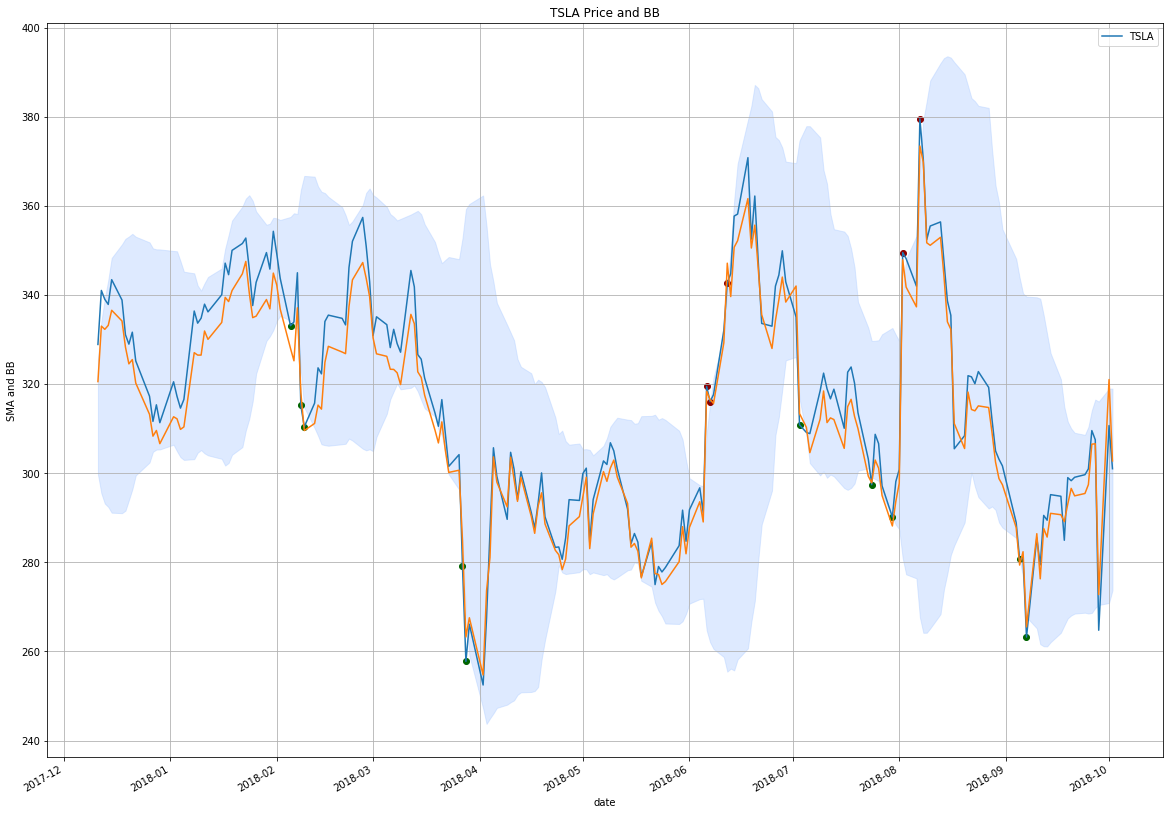

In [52]:

ax0 = df_tsla246.plot(title='{} Price and BB'.format(symbol),figsize=(20,15))
ax0.fill_between(df_tsla246.index, df_bollinger246['lower'], df_bollinger246['upper'], color='#ADCCFF', alpha='0.4')
plt.plot(df_tsla246.index, predx_test)

k = 0
for day, data in df_bollinger246.iterrows():

    if data['TSLA'] >= data['upper'] and predx_test[k] >= data['upper']:
        #Sell
        print(data['TSLA'] , ' ' , predx_test[k])
        ax0.scatter(x=day, y=df2.loc[day, 'TSLA'], color='darkred')
        k = k+1

    elif data['TSLA'] < data['lower'] and predx_test[k] < data['lower']:
        #Buy
        ax0.scatter(x=day, y=df2.loc[day, 'TSLA'], color='darkgreen')
        k = k+1
    else:
        k = k+1
        continue

ax0.set_xlabel('date')
ax0.set_ylabel('SMA and BB')
ax0.grid()
plt.show()